# Disentanglement Provides a Unified Estimation for Quantum Entropies and Distance Measures (Code)

Myeongjin Shin, Seungwoo Lee, Junseo Lee, Mingyu Lee, Donghwa Ji, Hyeonjun Yeo, Kabgyun Jeong

Paper link: [Arxiv](https://arxiv.org/abs/2401.07716)

This is a code example which reproduces the result on **distance measures** in the original paper. We assume you have read on the jupyter notebook of entropies.

## Environment Setup & Imports

In [1]:
!pip install -q numpy==1.26.4
!pip install -q matplotlib==3.7.1
!pip install -q qiskit==0.46.2
!pip install -q pennylane==0.37
!pip install -q torch==2.4

import csv
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy.linalg import eig, matrix_rank
from qiskit import quantum_info
from torch.autograd import Variable
import pennylane as qml

np.random.seed(40)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 53.9 MB/s eta 0:00:00


## Distance Measures

Trace distance: $T(\rho, \sigma) = \frac{1}{2}\textrm{Tr}(|\rho - \sigma|)$

Fidelity: $F(\rho, \sigma) = (\textrm{Tr}(\sqrt{\sqrt{\rho} \sigma \sqrt{\rho}}))^2$

In [2]:
def trace_distance(matrix1, matrix2):
    """
    Calculate the trace distance between two density matrices.

    Args:
        matrix1 (numpy.ndarray): The first density matrix.
        matrix2 (numpy.ndarray): The second density matrix.

    Returns:
        float: The trace distance between the two density matrices.
    """
    # Calculate the eigenvalues of the difference between the two matrices
    eigvalues, _ = eig(matrix1 - matrix2)

    # Sum the absolute values of the real parts of the eigenvalues
    distance = 0
    for e in eigvalues:
        distance += np.abs(np.real(e) / 2)

    return distance


def fidelity(matrix1, matrix2):
    """
    Calculate the fidelity between two density matrices.

    Args:
        matrix1 (numpy.ndarray): The first density matrix.
        matrix2 (numpy.ndarray): The second density

    Returns:
        float: The fidelity between the two density matrices.
    """
    return qml.math.fidelity(matrix1, matrix2)

## Preparing States $\rho_{AB}$ and $\sigma_{AB}$

Now we prepare 2 states, with the same way we did on the entropy version.

In [3]:
num_qubits = 6
measure_qubits = 3
unitary_qubits = 2 * num_qubits - measure_qubits

num_state = 2
unitary_array = []  # Array of random unitary matrices.
matrix_array = []  # Array of density matrices rho_AB and sigma_AB.

# Generating random pure state consisting of "unitary_qubits".
for i in range(num_state):
    U1 = quantum_info.random_unitary(dims=2 ** (measure_qubits), seed=10+i).data
    U2 = quantum_info.random_unitary(dims=2 ** (unitary_qubits - measure_qubits), seed=20+i).data
    U = np.kron(U1, U2)
    unitary_array.append(U)

dev = qml.device("default.qubit", wires=unitary_qubits)
mixed_dev = qml.device("default.mixed", wires=num_qubits)

def init(unitary):
    qml.QubitUnitary(unitary, wires=[i for i in range(unitary_qubits)])

@qml.qnode(dev)
def density_matrix(unitary, a, b):
    init(unitary)
    return qml.density_matrix(wires=[i for i in range(a, b)])  # Calculate partial trace

# Get partial trace to get a mixed state consisting of "num_qubits".
for U in unitary_array:
    matrix = np.array(density_matrix(U, 0, num_qubits))
    matrix_array.append(matrix)

In [4]:
print(unitary_array[0].shape)  # (2 ** unitary_qubits, 2 ** unitary_qubits)
print(matrix_array[0].shape)   # (2 ** num_qubits, 2 ** num_qubits)

(512, 512)
(64, 64)


## Circuit Ansatz

Implementation is the same as the entropy version.

In [5]:
def layer(params, j, n_qubits):
    """
    A layer of DEQNN.
    The detailed structure of a layer is described above.
    """

    for i in range(n_qubits):
        qml.RX(params[i, j, 0], wires=i)
        qml.RY(params[i, j, 1], wires=i)
        qml.RZ(params[i, j, 2], wires=i)
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])


def DEQNN(params, num_layers):
    """
    Run DEQNN, which is applying layers sequentially.
    The detailed structure of DEQNN is described above.
    """
    for j in range(num_layers):
        layer(params, j, num_qubits)


@qml.qnode(dev)
def circuit_matrix(U, params, num_layers, a, b):
    """
    Given an initial unitary, run DEQNN and returns a density matrix from a-th qubit to (b-1)-th qubit.
    """

    # Prepare initial pure unitary
    init(U)

    # Run DEQNN
    DEQNN(params, num_layers)

    # Return density matrix of the subsystem
    return qml.density_matrix(wires=[i for i in range(a, b)])


@qml.qnode(mixed_dev, interface="torch")
def loss_fn(matrix, params, num_layers):
    """
    A loss function of DEQNN,
    Given a density matrix, run the circuit and conduct observation, which is projection to the |0> basis.
    It gives the probability of observing 0 on the "measure_qubits".
    """

    # Prepare initial density matrix
    qml.QubitDensityMatrix(matrix, wires=[i for i in range(num_qubits)])

    # Run DEQNN
    DEQNN(params, num_layers)

    # Project to |0> basis to get the probability of getting 0 for all measure_qubits.
    observable = torch.zeros([2 ** measure_qubits, 2 ** measure_qubits])
    observable[0][0] = 1.0

    return qml.expval(qml.Hermitian(observable, wires=range(measure_qubits)))

Note that our loss function of DEQNN is independent to the property we want to estimate.

## Training DEQNN

In our implementation of DEQNN, we use 60 layers.

In [6]:
# Parameters of DEQNN
num_layers = 60
qnn_params = np.random.normal(0, 2 * np.pi, (num_qubits, num_layers, 3))
qnn_params = Variable(torch.tensor(qnn_params), requires_grad=True)

First, we calculate the entropies of original state (ground-truth) and the entropies of the state after applying DEQNN before any optimization.

In [7]:
# Ground truth
trace_distance_gt = trace_distance(matrix_array[0], matrix_array[1])
fidelity_gt = fidelity(matrix_array[0], matrix_array[1])

print(f"Ground-truth trace distance: {trace_distance_gt}")
print(f"Ground-truth fidelity: {fidelity_gt}")

Ground-truth trace distance: 0.9739458313060119
Ground-truth fidelity: 0.04798680302797363


In [8]:
# Estimated value
trace_distance_est = []
fidelity_est = []

m1 = circuit_matrix(unitary_array[0], qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()
m2 = circuit_matrix(unitary_array[1], qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()

# Calculate each entropies
trace_distance_est.append(trace_distance(m1, m2))
fidelity_est.append(fidelity(m1, m2))

# Calculate loss
purity = 0
for matrix in matrix_array:
    purity += loss_fn(matrix, qnn_params, num_layers)
loss = 1 - purity / num_state

print(f'Loss after 0 steps: {loss}')
print(f"Estimated trace distance: {trace_distance_est[-1]}")
print(f"Estimated fidelity: {fidelity_est[-1]}")

Loss after 0 steps: 0.8721023523151323
Estimated trace distance: 0.2982177639133702


Now, optimize DEQNN to preserve each entropies.

Here, even if we have two density matrices $\rho_{AB}$ and $\sigma_{AB}$, **we just find one $U$ that sucessfully disentangles two density matrices**, rather than optimizing differenct disentangling unitaries.

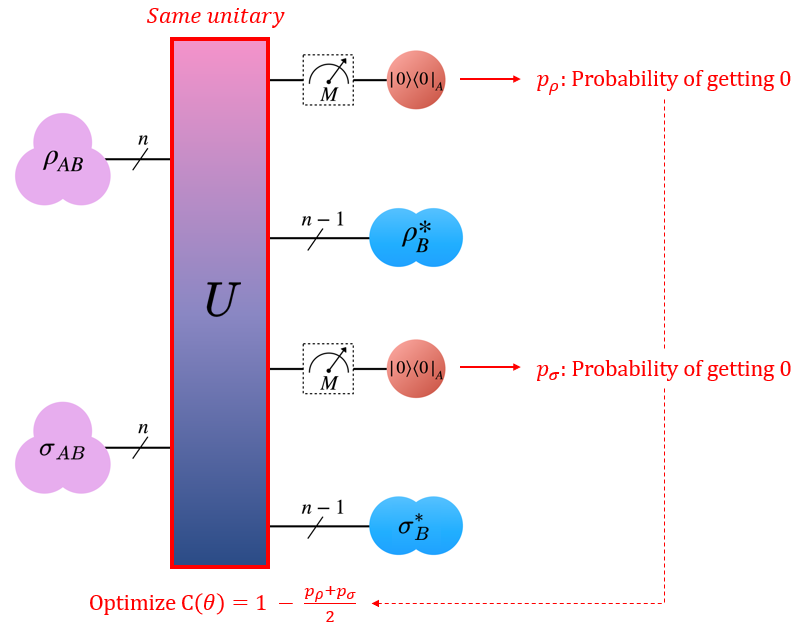

In [9]:
optimizer = torch.optim.Adam([qnn_params], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

steps = 500
for n in range(steps):
    optimizer.zero_grad()
    purity = 0
    for matrix in matrix_array:
        purity += loss_fn(matrix, qnn_params, num_layers)
    loss = 1 - purity / num_state
    loss.backward()
    optimizer.step()

    # Run DEQNN and get the resulting density matrix
    m1 = circuit_matrix(unitary_array[0], qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()
    m2 = circuit_matrix(unitary_array[1], qnn_params, num_layers, measure_qubits, num_qubits).detach().numpy()

    # Calculate entropies
    trace_distance_est.append(trace_distance(m1, m2))
    fidelity_est.append(fidelity(m1, m2))

    # Keep track of progress every 10 steps
    if n % 10 == 9 or n == steps - 1:
        print(f'Loss after {n + 1} steps: {loss}')
        print(f"Estimated trace distance: {trace_distance_est[-1]}")
        print(f"Estimated fidelity: {fidelity_est[-1]}")
        print()

Loss after 10 steps: 0.38180006107847597
Estimated trace distance: 0.5940443941228312
Estimated fidelity: 0.5761953337590792

Loss after 20 steps: 0.2526589506981364
Estimated trace distance: 0.7078493422197558
Estimated fidelity: 0.43955256852734714

Loss after 30 steps: 0.18734529245165887
Estimated trace distance: 0.7783014566022471
Estimated fidelity: 0.34605013083067554

Loss after 40 steps: 0.152021593979357
Estimated trace distance: 0.8114665876619324
Estimated fidelity: 0.3037033613198093

Loss after 50 steps: 0.13006612573837484
Estimated trace distance: 0.8322899922573644
Estimated fidelity: 0.281718378918235



KeyboardInterrupt: 